In [1]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/recyclens_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [5]:
camera_port = 0
ramp_frames = 30
import time

In [6]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [8]:
from IPython.display import Image
from google.colab.patches import cv2_imshow
from PIL import Image as Img

In [9]:
classes = {
    0: 'aluminium foil',
    1: 'biological',
    2: 'book',
    3: 'brown glass',
    4: 'cardboard',
    5: 'clear glass',
    6: 'clothes',
    7: 'e-waste',
    8: 'green glass',
    9: 'metal',
    10: 'paper',
    11: 'plastic',
    12: 'shoes',
    13: 'trash'
}

'NoneType' object has no attribute 'split'
starting


<IPython.core.display.Javascript object>

picture taken
Saved to photo.jpg


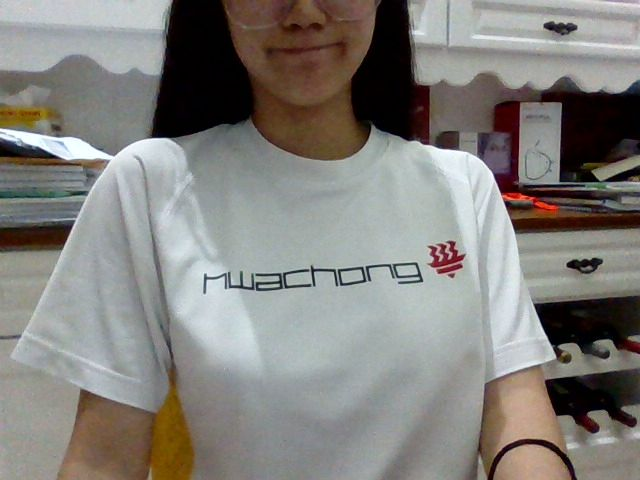

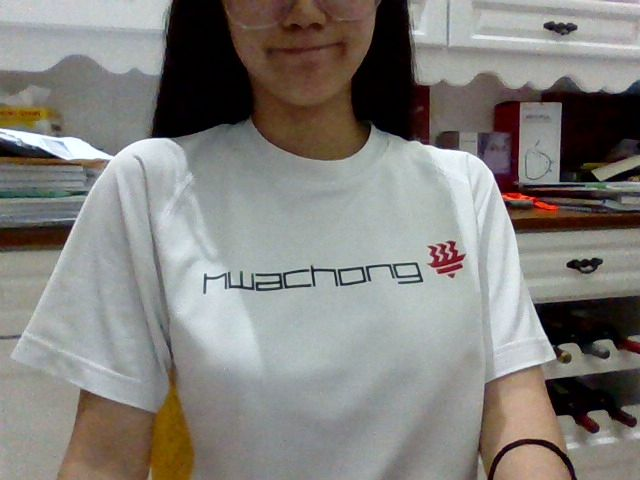

clothes
starting


<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

In [10]:
while True:
    print("starting")
    try:
      filename = take_photo()
      print("picture taken")
      print('Saved to {}'.format(filename))
    
      # Show the image which was just taken.
      display(Image(filename))

      image_path = filename
      img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
      #cv2_imshow(img)

      img = tf.keras.preprocessing.image.array_to_img(img)
      img = img.resize((300,300), Img.ANTIALIAS)

      input_shape = input_details[0]['shape']
      input_tensor = np.array(np.expand_dims(img,0))

      input_index = interpreter.get_input_details()[0]["index"]
      interpreter.set_tensor(input_index, input_tensor)
      interpreter.invoke()
      output_details = interpreter.get_output_details()

      output_data = interpreter.get_tensor(output_details[0]['index'])
      pred = np.squeeze(output_data)

      highest_pred_loc = np.argmax(pred)
      print(classes[highest_pred_loc])

      time.sleep(2)

    except Exception as err:
      # Errors will be thrown if the user does not have a webcam or if they do not
      # grant the page permission to access it.
      print(str(err))